# Storms in Barrier3D
Storms in Barrier3D are be described by 3 variables: storm duration, the highest runup elevation (Rhigh), and the lowest runup elevation (Rlow). In this notebook, we describe how to generate a list of synthetic storms for use in Barrier3D following the methods of Wahl et al. (2016) for a copula-based multivariate sea-storm model (MSSM). The MSSM model is developed using wave hindcast and water-level data from the Virgina Coastal Reserve and accounts for interdependencies between these three variables. We then illustrate how the list of synthetic storms can be used to generate annual storm time series (i.e., many storms per model year) for use in Barrier3D. Most of the text below describing the MSSM is taken from the Supplement of Reeves et al., 2021.

## Multivariate Sea Storm Model
The MSSM model `multivariateSeaStorm.m` (located in the `tools` folder) was written in Matlab in order to utilize the t-tide package, which allows for robust fitting of tidal constituents to water level time series, and therefore sadly cannot be run in this notebook. We provide a sample call below and describe its components herein. 

`[stStorms, stSimStorms] = multivariateSeaStorm(sCopula, sWIS_filename, sWaterLevel_filename, fBeta, fBermEl, nSimStorm, bPlot, sOutput_filename)`

The MSSM model requires the following inputs: 

`
% Inputs:
%       sCopula              - copula to be fitted to storm variables; options are "c-vine", "d-vine", "gaussian",  %                              or "t"
%       sWIS_filename        - .onlns file downloaded from a USACE Wave Information Studies (WIS) bouy; must 
%                              contain hourly records of wave height (m)
%       sWaterLevel_filename - .txt file that contains hourly records of total water level in m NAVD88 as second 
%                              column, first column is datetime; downloaded for each year from NOAA;
%                              must be either the same length or longer than WIS time record
%       fBeta                - beach slope 
%       nSimStorm            - number of simulated storms to create
%       fBermEl              - erosion threshold; Wahl used 5% of dune toe heights; we use the average berm 
%                              elevation (m NAVD88)
%       bPlot                - boolean for plotting
%       sOutputFilename      - string of prefix for csv output filename
`

In the example that follows, we utilize a 35 year record of hourly wave hindcast data – including wave height (Hs) and wave period (Tp) – from the USACE’s Wave Information Studies buoy offshore Hog Island in the Virginia Coast Reserve (Station 63183, 22 m water depth) and hourly records of water level from the nearest NOAA tide gauge (Station 8631044, Wachapreague, VA) to create a list of 20,000 synthetic storms. We specify a berm elevation of 1.9 m (the average along Hog Island) and beach slope of 0.04. The c-vine produced the highest $\tau$ values (Kendall's Corelation Coefficient) -- over the elliptical Gaussian and T-student copulas, as well as the d-vine copula -- and is therefore shown here.

`[stStorms, stSimStorms] = multivariateSeaStorm("c-vine", "ST63183_v03.onlns", "Tide-8631044-Combined.txt", 0.04, 1.9, 20000, true, "StormList_20k_VCR_Berm1pt9m_Slope0pt04.csv")`

<img align="left" width="600" height="600" src="Fig1-QC-VCR_Berm1pt9m_Slope0pt04.png">  

Within `multivariateSeaStorm.m`, we first process the data by removing the 365-day (1 yr) running median. This differs from the 30-day running median used in Wahl et al. (2016), namely because we desired to maintain seasonal trends and only account for non-stationarity in wave and water level parameters due to inter-annual and decadal variability. The median of the last 3 years is then applied to the entire time series such that the new time series is representative of the current climate. A year-by-year tidal analysis is performed using t_Tide (Pawlowicz et al., 2002) to obtain the tidal amplitude $\eta_A$ and non-tidal residual $\eta_{NTR}$. Lastly, the representative highest elevation of the landward margin of runup (Rhigh, i.e. the total water level) is calculated as the sum of the maximum 2% exceedance of runup, following Stockdon et al. (2006), and the contemporaneous (corrected) water level elevation from the tide gauge. The representative lowest runup elevation (Rlow), below which any part of the barrier is considered continuously subaqueous during a storm, is taken as Rhigh – swash/2 (Figure 1). While wave direction is processed as part of the MSSM, it is not required as input for Barrier3D and is therefore not discussed herein.

### Figure 1. Timeseries corrected for non-stationarity due to inter-annual and decadal variability 

<img align="left" width="600" height="600" src="Fig2-TWL-VCR_Berm1pt9m_Slope0pt04.png">

Storm events are then extracted from the corrected time series using the same metrics as Wahl et al. (2016), i.e., we derive a set of storm events by conditioning on Hs. Events are identified as periods of 8 or more consecutive hours with deep-water significant wave heights greater than 2.1 m, or rather the minimum monthly averaged wave height for periods in which waters levels exceed the berm elevation (Figure 2). The remaining variables used to define the independent multivariate storm events for use in Barrier3D include $\eta_A$, $\eta_{NTR}$, $Tp$, and storm duration. We discard storms with concomitant values of surge that are negative and identify new storms when Hs drops below the 2.1 m threshold for 24 hours or more (cf. Li et al., 2014). This method results in 282 independent multivariate sea-storm events for the example inputs shown here.

### Figure 2. Wave height threshold used to define storms (i.e., the minimum monthly averaged wave height for periods when the TWL exceeded the berm elevation).

<img align="left" width="600" height="600" src="Fig3-Hist-VCR_Berm1pt9m_Slope0pt04.png">

### Figure 3. Histograms of the empirical and synthetic storms

We *slightly* improve upon the copula-based approach of Wahl et al. (2016) for modeling the interdependencies between sea-storm variables through the use of vine copulas, a class of copulas that has been shown to outperform standard higher dimensional copulas in hydrologic applications (e.g., Daneshkhah et al., 2016; Jane et al., 2020) and does a slightly better job here. The MvCAT toolbox (Sadegh et al., 2017) is first used to find marginal distributions that best fit each variable ($\eta_{NTR}$: Weibull; Hs and storm duration: Generalized Pareto; Tp: Generalized Extreme Value). The observed data are then transformed to the copula scale (the unit hypercube) by finding their rank and then rescaling the ranks by 1/(N+1) where N = 282 events. Using the VineCopula R package (Nagler et al., 2020), we fit a C-vine, D-vine, and t-Student copula (as used in Wahl et al. (2016)) to the transformed four-dimensional data set in order to identify the most suitable copula for modeling interdependencies (the program `mssmVines.R` is called from within Matlab). We found through comparison of Kendall’s correlation coefficient $\tau$ that the C-vine best captures the underlying dependence structure. We then generate 20,000 random samples (quadruplets) from the C-vine copula and then use the inverse of the fitted marginal CDFs to transform the simulated data from unit hypercube space back to the original scale of the data. As the tidal amplitude varies within a restricted range, we sample $\eta_A$ directly from its empirical CDF for each of the 20,000 synthetic storm events.

## Creating storm time series

Once the list of synthetic storms has been created, it can be used to generate annual storm time series (i.e., zero to many storms per year) for use in Barrier3D. The storm time series can be created using one of three functions, all of which are located in `Tools.Barrier3D_MakeTimeSeries`:
* `yearly_storms_from_MSSM` - user specifies the mean and standard deviation for a normal distribution, which is then used to select a random number of storms to be pulled from the MSSM list each year.
* `frequency_storms_from_MSSM` - user specifies the Rhigh (total water level) and frequency of a return period storm; the closest match to the Rhigh is found in the MSSM list and corresponding variables Rlow and duration are then simulated at the specified frequency.
* `shift_storm_intensity` - this function shifts the TWL distribution created in `yearly_storms_from_MSSM` to the left or right to produce storms of different "intensity".

Below, we show example storm time series for a 1000 year Barrier3D simulation using each of these methods. The first example produces a storm time series with an average of 8.3 storms per model year; then, we shift the same storm distribution to the right to preferentially select storms with higher intensity (i.e., higher TWLs). Lastly, we create a time series of a 50 year return period storm for the Virgina Coastal Reserve. We estimate that a 50 year storm produces a maximum 2.0 m TWL (above MHW) using the NOAA Annual Exceedance Probability Curves at the Chesapeake Bay Bridge Tunnel (https://tidesandcurrents.noaa.gov/est/curves.shtml?stnid=8638863), which produces a TWL that is 0.5 m greater than the berm elevation.

Max TWL (m MHW):  4.0442
Max Rexcess (m above berm):  2.6041999999999996
% Rhigh > BermEl:  19.337479071992348
% Rlow  > BermEl:  1.2915570437694333


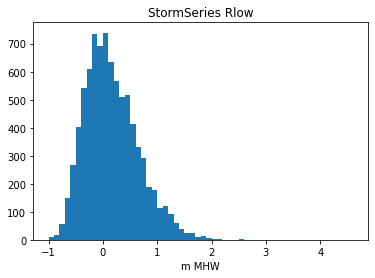

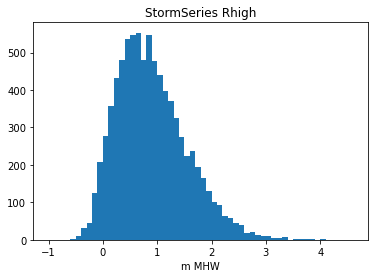

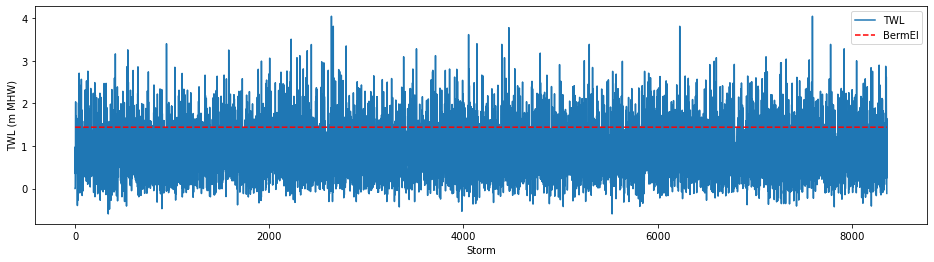

In [1]:
from barrier3d.utilities.Barrier3D_MakeTimeSeries import yearly_storms_from_MSSM, frequency_storms_from_MSSM, shift_storm_intensity

StormSeries_NormDist = yearly_storms_from_MSSM(
    datadir=".",
    storm_list_name="StormList_20k_VCR_Berm1pt9m_Slope0pt04.csv",  # can by .py or .csv
    mean_yearly_storms=8.3,
    SD_yearly_storms=5.9,
    MHW=0.46,  # m NAVD88
    StormStart=2,
    BermEl=1.9,  # m NAVD88, just used for plotting
    model_years=1000,
    bPlot=True,
    bSave=False,
    output_filename="StormList_1kyrs_VCR_Berm1pt9m_Slope0pt04",
)

[distfit] >fit..
[distfit] >transform..
[distfit] >[beta] [0.31 sec] [RSS: 0.0096785] [loc=-0.219 scale=15.008]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


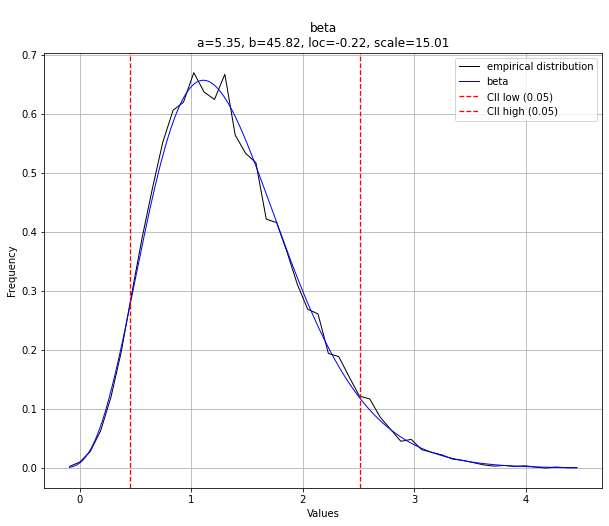

Max TWL (m MHW):  4.0442
Max Rexcess (m above berm):  2.6041999999999996
% Rhigh > BermEl:  24.627813040969418
% Rlow  > BermEl:  1.9619157530294287


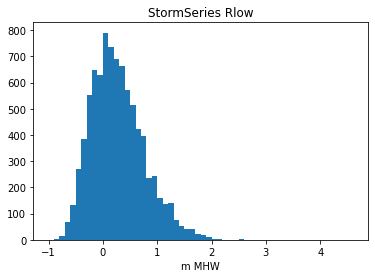

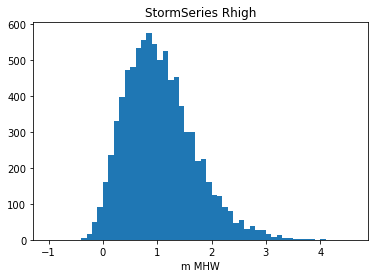

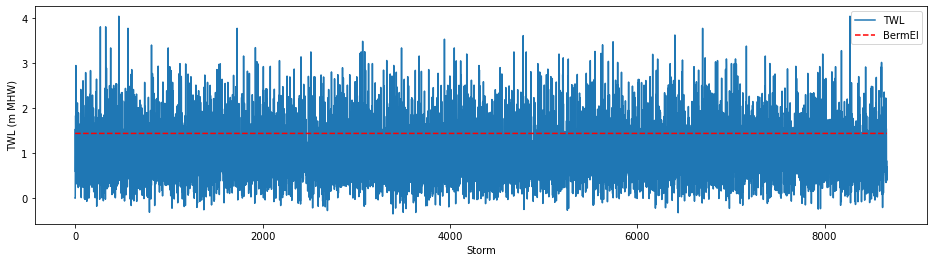

In [2]:
StormSeries_Shifted = shift_storm_intensity(
    datadir=".",
    storm_list_name="StormList_20k_VCR_Berm1pt9m_Slope0pt04.csv",  # can by .py or .csv
    mean_yearly_storms=8.3,
    SD_yearly_storms=5.9,
    shift=0.15,  # shift the TWL distribution to the right (i.e., increase intensity), m NAVD88, typically [-0.15, 0.15]
    MHW=0.46,  # m NAVD88
    StormStart=2,
    BermEl=1.9,  # m NAVD88, just used for plotting
    model_years=1000,
    bPlot=True,
    bSave=False,
    output_filename="StormList_10kyrs_VCR_Berm1pt9m_Slope0pt04-lowIntensity",
)

Max TWL (m MHW):  1.5000999999999998
Max Rexcess (m above berm):  0.0600999999999996
% Rhigh > BermEl:  99.9
% Rlow  > BermEl:  0.0


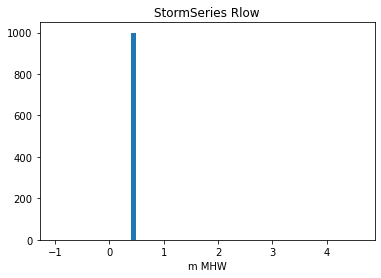

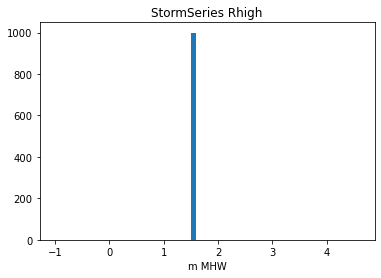

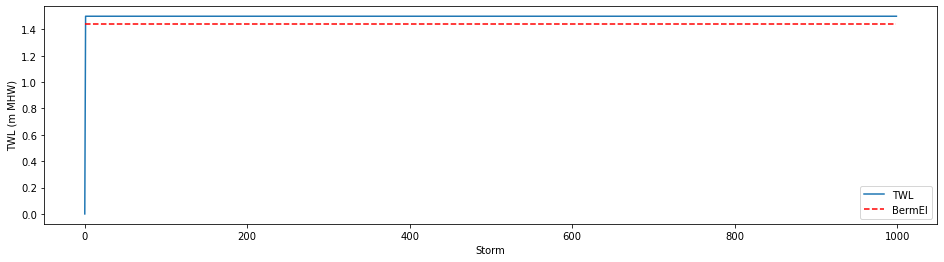

In [3]:
"""
    For demonstration purposes, I'm going to simulate a 15 year storm (TWL=1.5 m MHW) every year.
"""

StormSeries_15yrReturnPeriod = frequency_storms_from_MSSM(
    datadir=".",
    storm_list_name="StormList_20k_VCR_Berm1pt9m_Slope0pt04.csv",  # can by .py or .csv
    MHW=0.46,
    return_period=1,  # 15, 50 years for VCR; note minimum of 1 year 
    return_period_TWL=1.5,  # 1.5, 2.0 for VCR, in m above MHW 
    StormStart=1,
    BermEl=1.9,  # just for plotting
    model_years=1000,
    bPlot=True,
    bSave=False,
    output_filename="StormList_15yrRP_2mTWL_1kyrs_VCR_Berm1pt9m_Slope0pt04",
)

## Use with the Barrier3D BMI (Version 2.0)

Barrier3D requires a storm time series input file for initialization (format can be .npy or .csv). The output storm time series from any of the three methods described above can optionally be saved to file (`bSave=True`) to initialize the model. Because the storm time series add stochasticity, it may be desireable for a user to run and then average many Barrier3D simulations, each utilizing a different storm time series (with no change in input parameters) without saving the storms to file. In this case, the user may simply initialize the model with a dummy storm time series, call one of the methods above, and replace the `StormSeries` variable. Here I show how to do this using the Barrier3D BMI and sans BMI (class only).

100%|██████████| 50/50 [02:44<00:00,  3.28s/it]


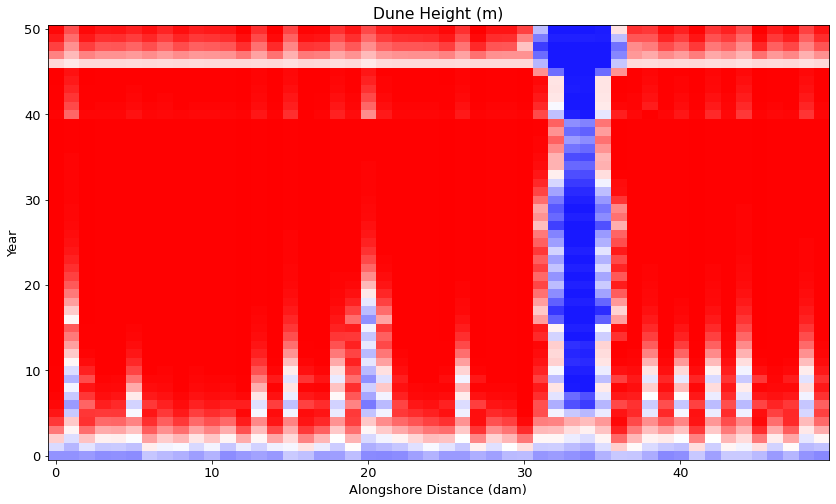

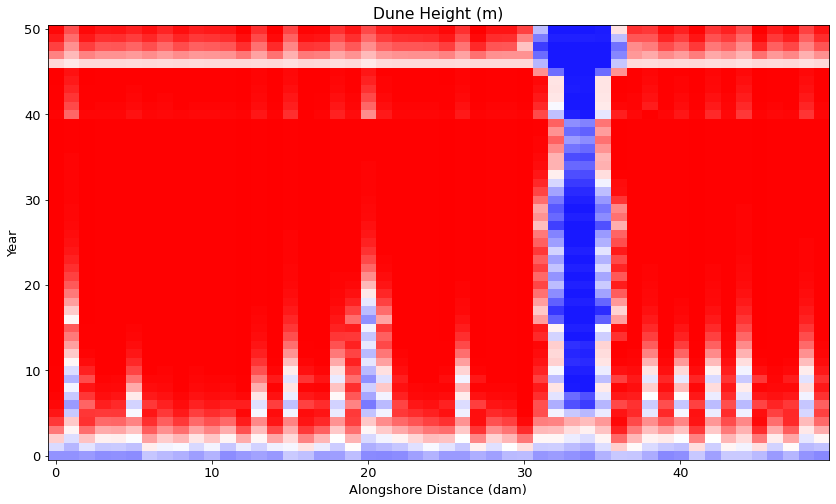

In [5]:
""" 
    NOTE TO NEW USERS: if using Barrier3D for the first time, remember to $ pip install -e .
"""
import pathlib

from tqdm import tqdm

from barrier3d import Barrier3dBmi
from barrier3d import Barrier3d

# specify data directory with initial conditions (user will need to change the prefix here!)
datadir = pathlib.Path("./data")
yaml_input_file = "barrier3d-parameters.yaml"

# create an instance of the BMI class, which is the model
barrier3d_bmi = Barrier3dBmi()
barrier3d_bmi.initialize(datadir / yaml_input_file)

# if you do not use the BMI, you can initialize using the built-in function from_yaml
barrier3d = Barrier3d.from_yaml(datadir) 

# now, swap out the StormSeries with one of the above!
barrier3d_bmi._model.StormSeries = StormSeries_NormDist  # the BMI variables are accessed under `_model`
barrier3d.StormSeries = StormSeries_NormDist

# run a short simulation
TMAX = barrier3d_bmi._model._TMAX 
for time_step in tqdm(range(1, TMAX)):
    
    # if you don't use the BMI, you need to call two update functions
    barrier3d.update()  
    barrier3d.update_dune_domain()
    
    # voila, only one call
    barrier3d_bmi.update()  # the BMI model by a time step   
    
from barrier3d.utilities import Barrier3D_Plotting_Functions as B3Dfunc

# plot dune height over time
B3Dfunc.plot_DuneHeight(barrier3d_bmi._model._DuneDomain, barrier3d_bmi._model._Dmax)
B3Dfunc.plot_DuneHeight(barrier3d._DuneDomain, barrier3d._Dmax)

Second, lets see what simulating a 15 year storm event every year does to dune dynamics!

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Text(0, 0.5, 'A dune elevation (m NAVD88)')

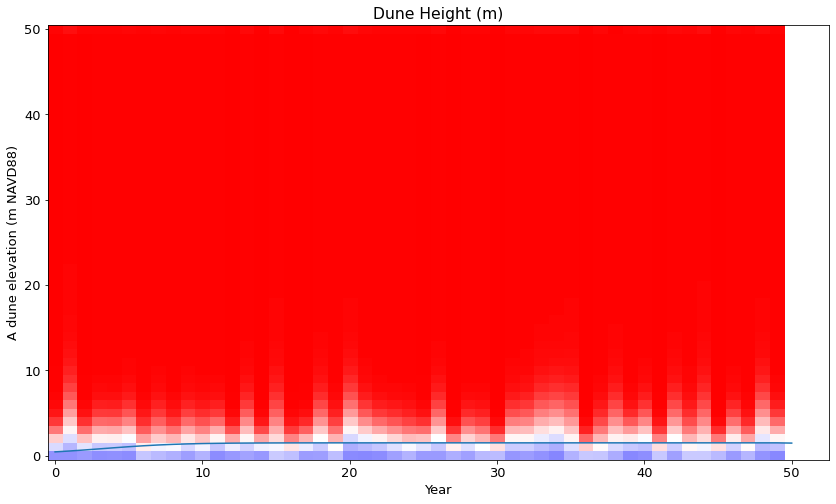

In [7]:
import matplotlib.pyplot as plt

# lets initialize a new model and try a return period storm
barrier3d = Barrier3d.from_yaml(datadir) 
barrier3d.StormSeries = StormSeries_15yrReturnPeriod

# because we changed the StormStart variable from the default of 2 to 1, we need to update in the class
barrier3d.StormStart = 1

# run a short simulation
TMAX = barrier3d._TMAX              
for time_step in tqdm(range(1, TMAX)):
    
    barrier3d.update()  
    barrier3d.update_dune_domain()

# plot dune height over time
B3Dfunc.plot_DuneHeight(barrier3d._DuneDomain, barrier3d._Dmax)

# and an example dune elevation
plt.plot(barrier3d._DuneDomain[:,1,0]*10) 
plt.xlabel('Year')
plt.ylabel('A dune elevation (m NAVD88)')